# Truss Analysis - CEE244 Programming - UMass Amherst

This code is designed to calculate the internal forces in a truss structure based on specified nodes, edges, support conditions, and external loads. Using basic principles of statics, it checks if the structure is statically determinate, sets up the equilibrium equations, and solves for the forces in each member and reactions at the supports. This was done by only the functions and operations we learned so far in CEE244 - Programming.

### Key Steps in the Code

1. **Define Nodes**: Each node's coordinates are defined in 2D space as `(x, y)` positions.

2. **Define Edges**: Connections between nodes are established as members of the truss, each represented by the start and end nodes.

3. **Define Supports**: Each node can have support conditions. Here, `1` indicates a restraint (support), and `0` indicates a free direction. This setup accommodates common support types:
    - **Pinned Support**: Both x and y directions are restrained.
    - **Roller Support**: Either x or y direction is restrained.

4. **Define Loads**: Loads are specified as forces in the x and y directions at each node, allowing for complex load cases across the structure.

5. **Visualize the Structure**: The `plottruss` function provides an initial visualization of the truss, showing nodes, edges, supports, and loads.

6. **Solve for Internal Forces**: Using the `solvetruss` function, the code calculates internal forces in each member based on equilibrium equations. The function also verifies that the truss is statically determinate. It then uses linear algebra to solve for the unknowns.

7. **Display Results with Forces**: After solving, the truss is plotted again, this time with force values annotated on each member. This helps visualize tension and compression within the structure.

### Application

This script is a foundational tool for truss analysis in civil and environmental engineering courses, particularly useful in courses like statics or structural analysis. It aids in understanding how forces distribute through a truss system and how different support and load configurations impact the structural response.

---

*Prepared by*: **Egemen Okte**, UMass Amherst



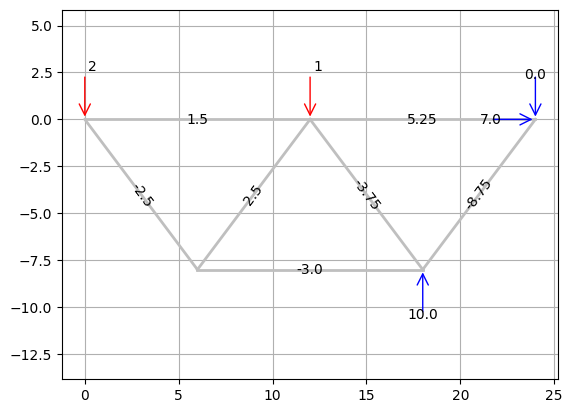

# Functions

Run the following cell to define essential functions for solving and plotting the truss. These functions utilize linear algebra to construct and solve the system of equations, allowing us to calculate internal forces and visualize the truss structure.

Notice how solving the structure is so much shorter than plotting it! But, visualizations are always crucial!


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, FancyArrowPatch, Circle

def solvetruss(nodes, edges, supports, loads):
    # ... (Same as before)

    P = nodes
    M = edges
    S = supports
    L = loads

    n_nodes = P.shape[0]
    n_members = M.shape[0]

    # Check for determinacy
    if n_nodes*2 != n_members + np.sum(S):
        print('System not determinate! I can only do statics, not structural analysis.')
        return None

    # Reshape loads into a column vector
    b = -L.T.flatten(order='F')

    # Reshape supports into a column vector
    SS = S.T.flatten(order='F')

    n_reactions = np.count_nonzero(SS > 0)

    n_unknowns = n_members + n_reactions

    A = np.zeros((n_nodes*2, n_unknowns))

    # For each member, compute the direction cosines and fill in the matrix A
    for i in range(n_members):
        # Nodes connected by member i
        n1 = int(M[i,0]) -1
        n2 = int(M[i,1]) -1

        # Coordinates of the nodes
        p1 = P[n1,:]
        p2 = P[n2,:]

        # Length and direction cosines
        length = np.linalg.norm(p2 - p1)
        angle = (p2 - p1)/length

        # Rows in A corresponding to node n1 and n2
        row_startnode = 2*n1
        row_endnode = 2*n2

        # Place the coefficients in A
        A[row_startnode:row_startnode+2, i] = angle
        A[row_endnode:row_endnode+2, i] = -angle

    # Now handle the supports
    bound = 0
    for j in range(len(SS)):
        if SS[j] > 0:
            A[j, n_members + bound] = SS[j]
            bound += 1

    # Now solve the system using Ax=b
    try:
        forces = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print('Matrix is singular, cannot solve the system.')
        return None

    return forces

def plottruss(nodes, edges, supports, loads, forces):
    P = nodes
    M = edges
    S = supports
    L = loads

    aspect = max(np.max(P[:,0])-np.min(P[:,0]), np.max(P[:,1])-np.min(P[:,1]))

    if forces is None or len(forces) == 0:
        colors = [0.1, 0.1, 0.1]
    else:
        colors = [0.75, 0.75, 0.75]

    forceplot = 0

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    plt.grid()
    # Adjust arrow size
    arrow_scale = aspect / 10

    # Draw members
    for i in range(M.shape[0]):
        n1 = int(M[i,0]) -1
        n2 = int(M[i,1]) -1

        x_values = [P[n1,0], P[n2,0]]
        y_values = [P[n1,1], P[n2,1]]

        ax.plot(x_values, y_values, color=colors, linewidth=2)

        if forces is not None and len(forces) > 0:
            xx = (P[n1,0] + P[n2,0]) /2
            yy = (P[n1,1] + P[n2,1]) /2
            delta_x = P[n2,0] - P[n1,0]
            delta_y = P[n2,1] - P[n1,1]
            ang = np.degrees(np.arctan2(delta_y, delta_x))
            # Adjust text alignment
            ax.text(xx, yy, str(round(forces[forceplot],2)), rotation=ang, ha='center', va='center')
            forceplot += 1

    maxload = aspect / 10

    # Draw supports and loads
    for i in range(P.shape[0]):
        # Supports
        if S[i,0] == 1 and S[i,1] == 1:
            # Fixed support (triangle)
            if forces is None or len(forces) == 0:
                side_length = aspect / 20
                h = side_length * np.sqrt(3) / 2
                x_center = P[i,0]
                y_center = P[i,1] - 2*h / 3  # Adjusted position
                triangle = RegularPolygon((x_center, y_center), numVertices=3, radius=side_length/np.sqrt(3), orientation=0, color='b')
                ax.add_patch(triangle)
            else:
                # Horizontal reaction arrow
                x = [P[i,0] - np.sign(round(forces[forceplot],2)+1e-12)*maxload, P[i,0]]
                y = [P[i,1], P[i,1]]

                arrow1 = FancyArrowPatch((x[0], y[0]), (x[1], y[0]), arrowstyle='->', mutation_scale=20, color='blue', zorder=10)
                ax.add_patch(arrow1)
                ax.text(x[0], y[0], str(round(abs(forces[forceplot]),2)), ha='center', va='center', zorder=10)

                # Vertical reaction arrow
                x = [P[i,0], P[i,0]]
                y = [P[i,1] - np.sign(round(forces[forceplot+1],2)+1e-12)*maxload, P[i,1]]

                arrow2 = FancyArrowPatch((x[0], y[0]), (x[1], y[1]), arrowstyle='->', mutation_scale=20, color='blue', zorder=10)
                ax.add_patch(arrow2)
                ax.text(x[0], y[0], str(round(abs(forces[forceplot+1]),2)), ha='center', va='center', zorder=10)

                forceplot += 2

        elif S[i,0] == 1 and S[i,1] == 0:
            # Horizontal roller support (circle)
            if forces is None or len(forces) == 0:
                radius = aspect / 40
                circle = Circle((P[i,0] + radius, P[i,1]), radius=radius, color='b')
                ax.add_patch(circle)
            else:
                x = [P[i,0] - np.sign(round(forces[forceplot],2))*maxload, P[i,0]]
                y = [P[i,1], P[i,1]]

                # Horizontal reaction arrow
                arrow = FancyArrowPatch((x[0], y[0]), (x[1], y[1]), arrowstyle='->', mutation_scale=20, color='blue', zorder=10)
                ax.add_patch(arrow)
                ax.text(x[0], y[0], str(round(abs(forces[forceplot]),2)), ha='center', va='center', zorder=10)
                forceplot +=1

        elif S[i,0] == 0 and S[i,1] == 1:
            # Vertical roller support (circle)
            if forces is None or len(forces) == 0:
                radius = aspect / 40
                circle = Circle((P[i,0], P[i,1] - radius), radius=radius, color='b')
                ax.add_patch(circle)
            else:
                x = [P[i,0], P[i,0]]
                y = [P[i,1] - np.sign(round(forces[forceplot],2))*maxload, P[i,1]]

                # Vertical reaction arrow
                arrow = FancyArrowPatch((x[0], y[0]), (x[1], y[1]), arrowstyle='->', mutation_scale=20, color='blue', zorder=10)
                ax.add_patch(arrow)
                ax.text(x[0], y[0], str(round(abs(forces[forceplot]),2)), ha='center', va='center', zorder=10)
                forceplot +=1

        # Loads
        if abs(L[i,0]) > 0:
            x = [P[i,0] - np.sign(L[i,0])*maxload, P[i,0]]
            y = [P[i,1], P[i,1]]

            arrow = FancyArrowPatch((x[0], y[0]), (x[1], y[1]), arrowstyle='->', mutation_scale=20, color='red', zorder=10)
            ax.add_patch(arrow)
            ax.text(x[0]+aspect/60, y[0]+aspect/60, str(abs(L[i,0])), ha='center', va='center', zorder=10)

        if abs(L[i,1]) > 0:
            x = [P[i,0], P[i,0]]
            y = [P[i,1] - np.sign(L[i,1])*maxload, P[i,1]]

            arrow = FancyArrowPatch((x[0], y[0]), (x[1], y[1]), arrowstyle='->', mutation_scale=20, color='red', zorder=10)
            ax.add_patch(arrow)
            ax.text(x[0]+aspect/60, y[0]+aspect/60, str(abs(L[i,1])), ha='center', va='center', zorder=10)

    plt.axis('equal')
    plt.show()





#Examples
The following examples are here to show you how the tool works!

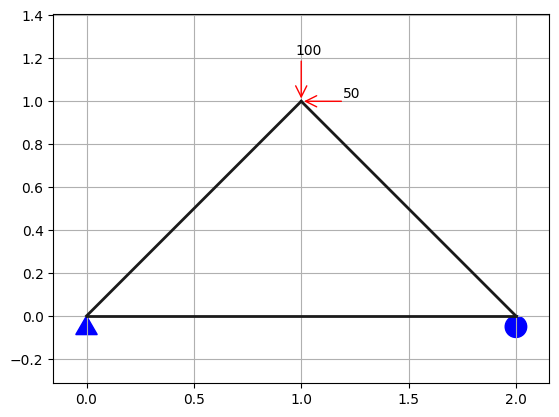

Forces: [-106.06601718  -35.35533906   25.           50.           75.
   25.        ]


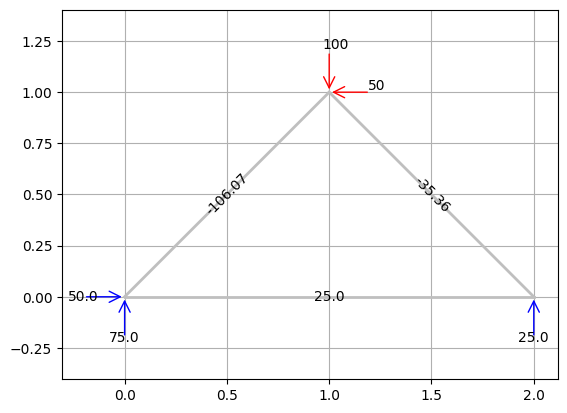

In [6]:
# Example 1

# Define nodes coordinates (x, y)
nodes = np.array([[0,0], [1,1], [2,0]])  # Each row represents a node's coordinates in 2D space. In this example, there is node 1, node 2 and node 3

# Define edges (member connectivity)
edges = np.array([[1,2], [2,3], [1,3]])  # Each row specifies a member with its start and end nodes (1-based indexing). In this example, element 1 is between nodes 1-2, element 2 between nodes 2-3 etc.

# Define support conditions [u_x, u_y; ...]
supports = np.array([[1,1], [0,0], [0,1]])  # Each row represents a node; '1' means restrained, '0' means free. In this case, node 1 is a pin support, node 3 is a roller, restricted to move in y direction
# Node 1 has a pin support (both x and y restrained), and node 3 has a roller support (y direction restrained only)

# Define nodal loads [F_x, F_y; ...]
loads = np.array([[0,0], [-50,-100], [0,0]])  # Each row represents the load in x and y directions at each node. In this case, node 1 is loaded with -50 in x and -100 in y
# Here, a downward load of -100 N is applied at node 2

# Plot the truss structure with nodes, edges, and supports
plottruss(nodes, edges, supports, loads, None)

# Solve for internal forces in each member of the truss
forces = solvetruss(nodes, edges, supports, loads)
print('Forces:', forces)  # Display the calculated forces for each member

# Plot the truss again, now with internal forces labeled on each member
plottruss(nodes, edges, supports, loads, forces)


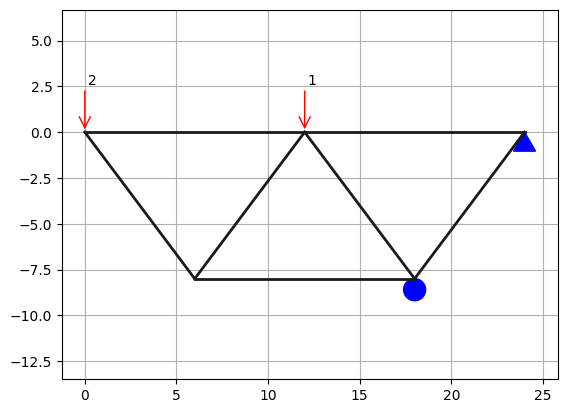

Forces: [-2.5   1.5   2.5  -3.   -3.75  5.25 -8.75 10.    0.   -7.  ]


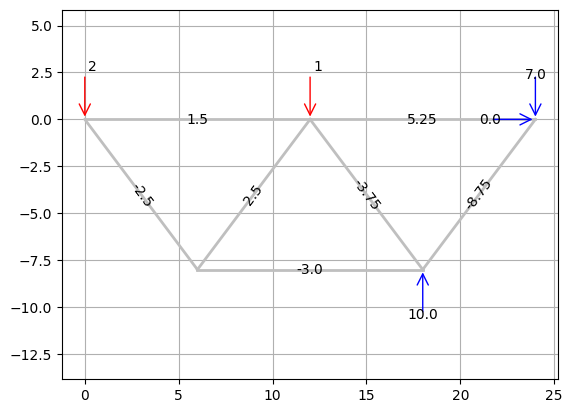

In [7]:
# Example 2

# Define nodes coordinates (x, y)
nodes = np.array([
    [0,0], [6,-8], [12,0], [18,-8], [24,0]
])

# Define edges (member connectivity)
edges = np.array([
    [1,2], [1,3], [2,3], [2,4], [3,4], [3,5], [4,5]
])

# Define support conditions (1 if restrained, 0 if free)
supports = np.array([
    [0,0], [0,0], [0,0], [0,1], [1,1]
])

# Define nodal loads
loads = np.array([
    [0,-2], [0,0], [0,-1], [0,0], [0,0]
])

# Plot the truss
plottruss(nodes, edges, supports, loads, None)

# Solve the truss
forces = solvetruss(nodes, edges, supports, loads)
print('Forces:', forces)

# Plot the truss with internal forces
plottruss(nodes, edges, supports, loads, forces)


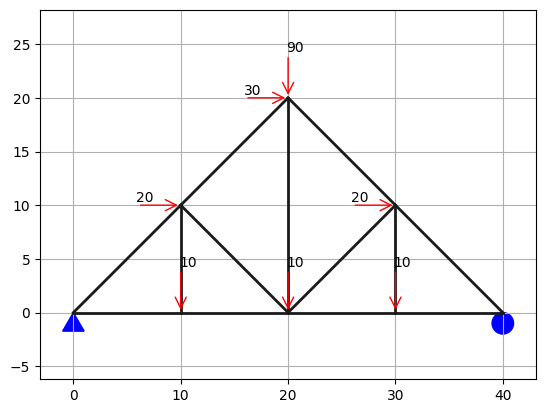

Forces: [ 105.          105.           85.           85.          -49.49747468
   10.          -21.21320344  -56.56854249   20.          -98.99494937
    7.07106781   10.         -120.2081528   -70.           35.
   85.        ]


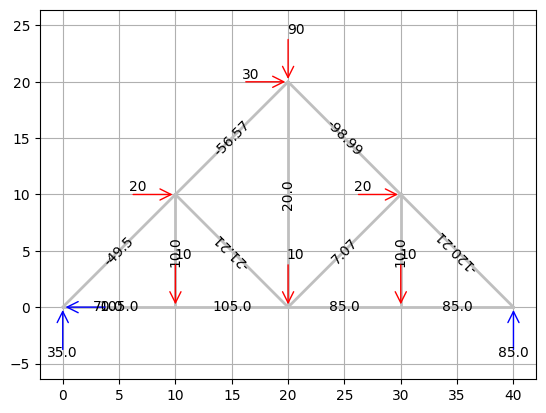

In [8]:
# Example 3

# Define nodes coordinates (x, y)
nodes = np.array([
    [0,0], [10,0], [20,0], [30,0], [40,0],
    [10,10], [20,20], [30,10]
])

# Define edges (member connectivity)
edges = np.array([
    [1,2], [2,3], [3,4], [4,5],
    [1,6], [2,6], [3,6], [6,7],
    [3,7], [7,8], [3,8], [4,8], [5,8]
])

# Define support conditions (1 if restrained, 0 if free)
supports = np.array([
    [1,1], [0,0], [0,0], [0,0], [0,1],
    [0,0], [0,0], [0,0]
])

# Define nodal loads
loads = np.array([
    [0,0], [0,-10], [0,-10], [0,-10], [0,0],
    [20,0], [30,-90], [20,0]
])

# Plot the truss
plottruss(nodes, edges, supports, loads, None)

# Solve the truss
forces = solvetruss(nodes, edges, supports, loads)
print('Forces:', forces)

# Plot the truss with internal forces
plottruss(nodes, edges, supports, loads, forces)